In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/study/table_data

/content/drive/My Drive/study/table_data


## ライブラリ

In [3]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
def seed_set(seed):
    """
    seedの固定

    Parameters
    --------------
    seed : int
        シード
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [5]:
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print("Device:", torch.cuda.get_device_name(current_device))

Device: Tesla P100-PCIE-16GB


## config

In [6]:
SEED = 0
TRAIN_FILE = './dataset/train.csv'
TEST_FILE = './dataset/test.csv'
SUB_FILE = './dataset/gender_submission.csv'
MODELS_DIR = "./models/"
CATEGORICAL = ['Sex', 'Cabin', 'Embarked']
NUMERICAL =  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
TARGET = 'Survived'
USE = CATEGORICAL + NUMERICAL
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 300

## データの確認

In [7]:
df_train = pd.read_csv(TRAIN_FILE)[USE+[TARGET]]
df_test = pd.read_csv(TEST_FILE)[USE]
df_train.head()

,Sex,Cabin,Embarked,Pclass,Age,SibSp,Parch,Fare,Survived
0,male,NaN,S,3,22.0,1,0,7.2500,0
1,female,C85,C,1,38.0,1,0,71.2833,1
2,female,NaN,S,3,26.0,0,0,7.9250,1
3,female,C123,S,1,35.0,1,0,53.1000,1
4,male,NaN,S,3,35.0,0,0,8.0500,0


In [8]:
# 欠損率
df_train.isnull().sum() / len(df_train)

Sex         0.000000
Cabin       0.771044
Embarked    0.002245
Pclass      0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Survived    0.000000
dtype: float64

In [9]:
df_test.isnull().sum() / len(df_test)

Sex         0.000000
Cabin       0.782297
Embarked    0.000000
Pclass      0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Fare        0.002392
dtype: float64

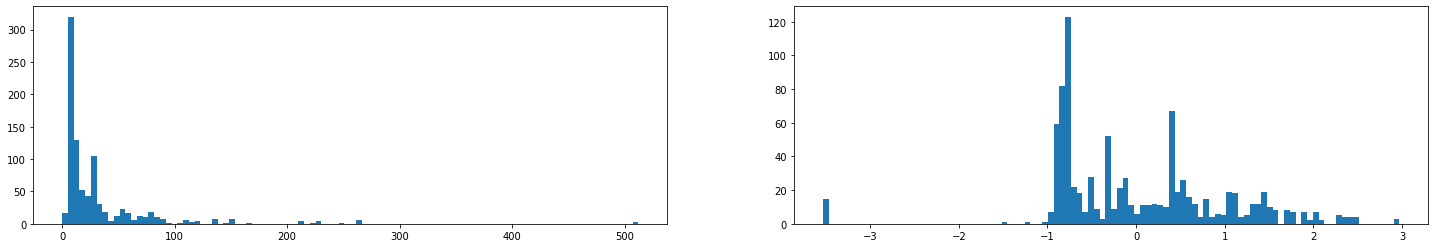

In [10]:
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(1, 2, 1)
ax.hist(df_train[['Fare']].values, bins=100)
# 正規分布へ変換する
pt = PowerTransformer(method='yeo-johnson')
pt.fit(df_train[['Fare']])
ax = fig.add_subplot(1, 2, 2)
ax.hist(pt.transform(df_train[['Fare']]), bins=100)

plt.show()

## 前処理

In [11]:
def preprocessing(df_train, df_test, cat_cols=CATEGORICAL, num_cols=NUMERICAL, target=TARGET):
    df = pd.concat([df_train.drop(columns=target), df_test])
    y = df_train[target]
    train_len = len(df_train)

    # 欠損埋め
    df[cat_cols] = df[cat_cols].fillna('None')
    df[num_cols] = df[num_cols].fillna(0)

    # 正規分布へ変換
    pt = PowerTransformer(method='yeo-johnson')
    pt.fit(df[num_cols])
    df[num_cols] = pt.transform(df[num_cols])

    # 標準化
    scaler = StandardScaler()
    scaler.fit(df[num_cols])
    df[num_cols] = scaler.transform(df[num_cols])

    # ラベルエンコーダ
    for col in df.columns:
        if col in cat_cols:
            df[col] = LabelEncoder().fit_transform(df[col])
            df[col]= df[col].astype('category')

    return pd.concat([df.iloc[:train_len], y], axis=1), df.iloc[train_len:]

df_train, df_test = preprocessing(df_train, df_test)
df_train

,Sex,Cabin,Embarked,Pclass,Age,SibSp,Parch,Fare,Survived
0,1,185,3,0.877646,0.101609,1.379985,-0.553298,-0.897788,0
1,0,106,0,-1.446992,0.815378,1.379985,-0.553298,1.317723,1
2,0,185,3,0.877646,0.295995,-0.682852,-0.553298,-0.805739,1
3,0,70,3,-1.446992,0.692828,1.379985,-0.553298,1.057907,1
4,1,185,3,0.877646,0.692828,-0.682852,-0.553298,-0.789560,0
...,...,...,...,...,...,...,...,...,...
886,1,185,3,-0.559108,0.342624,-0.682852,-0.553298,-0.297087,0
887,0,40,3,-1.446992,-0.053856,-0.682852,-0.553298,0.529329,1
888,0,185,3,0.877646,-1.583508,1.379985,1.867185,0.291735,0
889,1,77,0,-1.446992,0.295995,-0.682852,-0.553298,0.529329,1


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Sex       891 non-null    category
 1   Cabin     891 non-null    category
 2   Embarked  891 non-null    category
 3   Pclass    891 non-null    float64 
 4   Age       891 non-null    float64 
 5   SibSp     891 non-null    float64 
 6   Parch     891 non-null    float64 
 7   Fare      891 non-null    float64 
 8   Survived  891 non-null    int64   
dtypes: category(3), float64(5), int64(1)
memory usage: 58.9 KB


In [13]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=TARGET), df_train[TARGET], test_size=0.20, random_state=SEED, shuffle=True) 
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 8), (179, 8), (712,), (179,))

In [14]:
cat_szs = [len(df_train[col].cat.categories) for col in CATEGORICAL]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (187, 50), (4, 2)]

## Pytorch Dataset, DataLoader

In [15]:
class ClassificationColumnarDataset(Dataset):
    def __init__(self, df, target, cat_cols=CATEGORICAL,):
        self.df_cat = df[cat_cols]
        self.df_num = df.drop(cat_cols, axis=1)
        
        self.X_cats = self.df_cat.values.astype(np.int64)
        self.X_nums = self.df_num.values.astype(np.float32)
        self.target = target.values.astype(np.int64)
        
    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return [self.X_cats[idx], self.X_nums[idx], self.target[idx]]

In [16]:
train_dataset = ClassificationColumnarDataset(X_train, y_train)
val_dataset = ClassificationColumnarDataset(X_val, y_val)
test_dataset = ClassificationColumnarDataset(df_test, pd.Series(np.zeros(len(df_test)).astype(np.int64)))

In [17]:
seed_set(SEED)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## model

In [18]:
# https://towardsdatascience.com/deep-learning-for-tabular-data-using-pytorch-1807f2858320
# https://towardsdatascience.com/deep-learning-using-pytorch-for-tabular-data-c68017d8b480
# https://arxiv.org/pdf/1604.06737.pdf

class TabularModel(nn.Module):
    def __init__(self, embedding_sizes, n_num):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_num = n_emb, n_num
        self.lin1 = nn.Linear(self.n_emb + self.n_num, 100)
        self.lin2 = nn.Linear(100, 70)
        self.lin3 = nn.Linear(70, 2)
        self.bn1 = nn.BatchNorm1d(self.n_num)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(70)
        self.emb_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)


    def forward(self, x_cat, x_num):
        x = [e(x_cat[:, i]) for i, e in enumerate(self.embeddings)]
        x = torch.cat(x, dim=1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_num)
        x = torch.cat([x, x2], dim=1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [19]:
seed_set(SEED)
model = TabularModel(emb_szs, len(NUMERICAL)).to(DEVICE)
compute_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

## 学習

In [20]:
seed_set(SEED)

hist = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

for epoch in range(EPOCHS):
    # 学習
    train_loss = 0.
    train_acc = 0.
    all_labels_train = []
    all_preds_train = []

    model.train()
    train_progress = tqdm(train_dataloader, total=len(train_dataloader), leave=False)
    for batch_idx, (cat_data, num_data, target) in enumerate(train_progress):
        train_progress.set_description(f'<Train> Epoch{epoch+1}')
        cat_data, num_data, target = cat_data.to(DEVICE), num_data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(cat_data, num_data)
        loss = compute_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_score(target.tolist(), output.argmax(dim=-1).tolist())
        all_labels_train += target.tolist()
        all_preds_train += output.tolist()

        train_progress.set_postfix(loss=train_loss/(batch_idx+1), acc=train_acc/(batch_idx+1))

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証
    val_loss = 0.
    val_acc = 0.
    best_acc = 0.
    all_labels_val = []
    all_preds_val = []    

    model.eval()
    val_progress = tqdm(val_dataloader, total=len(val_dataloader), leave=False)
    with torch.no_grad():
        for batch_idx, (cat_data, num_data, target) in enumerate(val_progress):
            val_progress.set_description(f'<Val> Epoch{epoch+1}')
            cat_data, num_data, target = cat_data.to(DEVICE), num_data.to(DEVICE), target.to(DEVICE)
            output = model(cat_data, num_data)
            loss = compute_loss(output, target)

            val_loss += loss.item()
            val_acc += accuracy_score(target.tolist(), output.argmax(dim=-1).tolist())
            all_labels_val += target.tolist()
            all_preds_val += output.tolist()

            val_progress.set_postfix(loss=val_loss/(batch_idx+1), acc=val_acc/(batch_idx+1))
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)

    # modelの保存
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), MODELS_DIR + f'best_NN_1.pth')


    # 学習状況を保存
    hist['train_loss'].append(train_loss)
    hist['train_accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

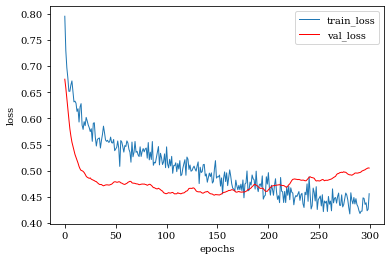

In [21]:
# 検証データの誤差の可視化
train_loss = hist['train_loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(train_loss)), train_loss, linewidth=1, label='train_loss')
plt.plot(range(len(val_loss)), val_loss, color='red', linewidth=1, label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

validation data best acc : 0.7877094972067039


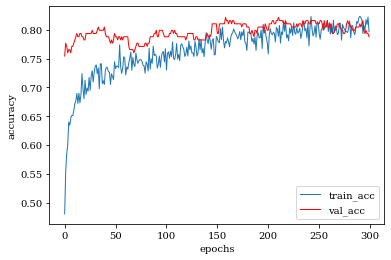

In [22]:
print(f'validation data best acc : {best_acc}')

# 検証データの精度の可視化
train_acc = hist['train_accuracy']
val_acc = hist['val_accuracy']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(train_acc)), train_acc, linewidth=1, label='train_acc')
plt.plot(range(len(val_acc)), val_acc, color='red', linewidth=1, label='val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## 提出ファイル作成

In [24]:
#　best modelの読み込み
model = TabularModel(emb_szs, len(NUMERICAL)).to(DEVICE)
model.load_state_dict(torch.load(MODELS_DIR + f"best_NN_1.pth"))

<All keys matched successfully>

In [25]:
outputs = []

model.eval()
test_progress = tqdm(test_dataloader, total=len(test_dataloader), leave=False)
with torch.no_grad():
    for batch_idx, (cat_data, num_data, _) in enumerate(test_progress):
        test_progress.set_description(f'<Test> Epoch{epoch+1}')
        cat_data, num_data = cat_data.to(DEVICE), num_data.to(DEVICE)
        output = model(cat_data, num_data)

        outputs += torch.argmax(torch.softmax(output, dim=1), dim=1).cpu().detach().tolist()

In [26]:
sub = pd.read_csv(SUB_FILE)
sub['Survived'] = outputs
sub.to_csv('./submission/NN_1.csv', index=False)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
